# BBC News Summary - ML/DL Project

A media monitoring project that classifies BBC news articles, discovers latent topics, and builds a reinforcement learning (RL) agent to decide whether to use a classical ML model, a deep learning model, or escalate a news item to humans.

## Project Overview

This notebook implements:
1. **News Article Classification** - Classify articles into categories (business, entertainment, politics, sport, tech)
2. **Topic Discovery** - Group articles into topics using clustering
3. **Reinforcement Learning Agent** - Decide when to use classical ML, deep learning, or human escalation


### 0. Imports & global config

In [32]:
# Standard library imports
import os
import re
import string

# IPython display for multiple outputs
from IPython.display import display

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning - model selection and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score
)

# Machine learning - feature extraction and dimensionality reduction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression


# Deep learning - TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Global configuration
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# Set random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

print("libraries imported successfully!")

libraries imported successfully!


### Part A: Data Mining and Preprocessing


#### A1. Load BBC dataset

**Dataset structure:**
```
BBC-News-Summary-ML-DL-Project/
└─ dataset/
   └─ News Articles/
       ├─ business/
       ├─ entertainment/
       ├─ politics/
       ├─ sport/
       └─ tech/
```

In [ ]:
DATA_DIR = "dataset/News Articles"

categories = []
texts = []
filenames = []

for category in os.listdir(DATA_DIR):
    category_path = os.path.join(DATA_DIR, category)
    if not os.path.isdir(category_path):
        continue
    for fname in os.listdir(category_path):
        fpath = os.path.join(category_path, fname)
        if not os.path.isfile(fpath):
            continue
        with open(fpath, "r", encoding="latin-1") as f:
            text = f.read().strip()
        categories.append(category)
        texts.append(text)
        filenames.append(fname)

df = pd.DataFrame({
    "category": categories,
    "text": texts,
    "filename": filenames
})

print("Dataset shape:", df.shape)

print("\nFirst 10 records:")
display(df.head(10))


Dataset shape: (2225, 3)

First 5 records:


,category,text,filename
0,business,Ad sales boost Time Warner profit\n\nQuarterly...,001.txt
1,business,Dollar gains on Greenspan speech\n\nThe dollar...,002.txt
2,business,Yukos unit buyer faces loan claim\n\nThe owner...,003.txt
3,business,High fuel prices hit BA's profits\n\nBritish A...,004.txt
4,business,Pernod takeover talk lifts Domecq\n\nShares in...,005.txt
5,business,Japan narrowly escapes recession\n\nJapan's ec...,006.txt
6,business,Jobs growth still slow in the US\n\nThe US cre...,007.txt
7,business,"India calls for fair trade rules\n\nIndia, whi...",008.txt
8,business,Ethiopia's crop production up 24%\n\nEthiopia ...,009.txt
9,business,Court rejects $280bn tobacco case\n\nA US gove...,010.txt


#### A2.  Display examples and class distribution

,category,text,filename
414,business,UK house prices dip in November\n\nUK house pr...,415.txt
420,business,LSE 'sets date for takeover deal'\n\nThe Londo...,421.txt
1644,sport,Harinordoquy suffers France axe\n\nNumber eigh...,332.txt
416,business,Barclays shares up on merger talk\n\nShares in...,417.txt
1232,politics,Campaign 'cold calls' questioned\n\nLabour and...,337.txt



Categories distribution:
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


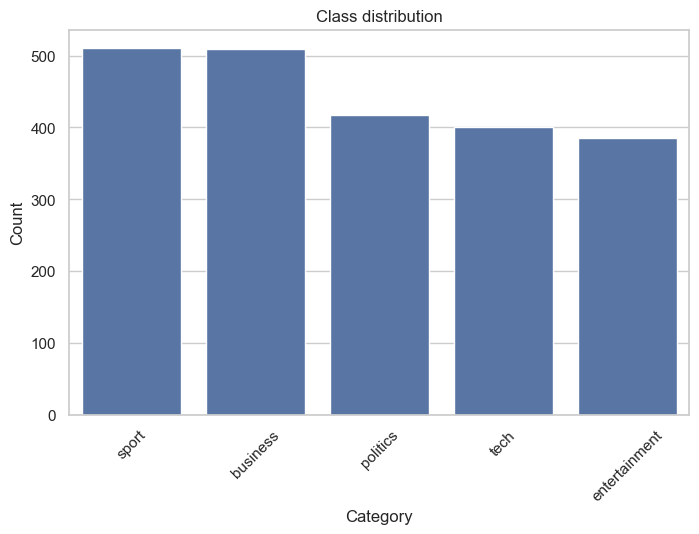

In [23]:
# Show a few examples
display(df.sample(5, random_state=RANDOM_STATE))

# Class distribution 
print("\nCategories distribution:")
class_counts = df["category"].value_counts()
print(class_counts)

sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title("Class distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


#### A3 – Text cleaning


In [25]:
# Clean text - lowercase, remove whitespace, punctuation/HTML.

def clean_text(text):
    # Converte all text to lowercase
    text = text.lower()
    # remove HTML tags
    text = re.sub(r"<.*?>", " ", text)
    # remove digits
    text = re.sub(r"\d+", " ", text)
    # remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # collapse whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["text"].apply(clean_text)
df[["category", "clean_text"]].head(10)


,category,clean_text
0,business,ad sales boost time warner profit quarterly pr...
1,business,dollar gains on greenspan speech the dollar ha...
2,business,yukos unit buyer faces loan claim the owners o...
3,business,high fuel prices hit bas profits british airwa...
4,business,pernod takeover talk lifts domecq shares in uk...
5,business,japan narrowly escapes recession japans econom...
6,business,jobs growth still slow in the us the us create...
7,business,india calls for fair trade rules india which a...
8,business,ethiopias crop production up ethiopia produced...
9,business,court rejects bn tobacco case a us government ...


#### A4. Prepare TF-IDF and tokenized sequences for DL.


A4.1. TF-IDF features (for ML)


In [26]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    stop_words="english"
)

X_tfidf = tfidf_vectorizer.fit_transform(df["clean_text"])
y = df["category"]

print("TF-IDF shape:", X_tfidf.shape)


TF-IDF shape: (2225, 5000)


A4.2. Tokenized sequences for DL

In [27]:
MAX_NUM_WORDS = 10000
MAX_SEQ_LEN = 300

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_text"])

sequences = tokenizer.texts_to_sequences(df["clean_text"])
X_seq = pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding="post", truncating="post")

word_index = tokenizer.word_index
print("Vocabulary size (full):", len(word_index))
print("Sequence tensor shape:", X_seq.shape)


Vocabulary size (full): 31519
Sequence tensor shape: (2225, 300)


A4.3. Train/test split for ML & DL

In [ ]:
label_encoder = LabelEncoder()
y_int = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# Get indices for train/test split to track original dataframe rows
indices = np.arange(len(y_int))
X_tfidf_train, X_tfidf_test, X_seq_train, X_seq_test, y_train_int, y_test_int, train_idx, test_idx = train_test_split(
    X_tfidf, X_seq, y_int, indices,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_int
)

y_train_cat = to_categorical(y_train_int, num_classes=num_classes)
y_test_cat = to_categorical(y_test_int, num_classes=num_classes)

print("Train size:", X_tfidf_train.shape[0], " Test size:", X_tfidf_test.shape[0])


Train size: 1780  Test size: 445


### Part B. Two News Classifiers
#### B1.1. Classical ML Model - Logistic Regression


In [36]:
ml_model = LogisticRegression(
    max_iter=2000,
    n_jobs=-1
)

ml_model.fit(X_tfidf_train, y_train_int)

y_ml_pred = ml_model.predict(X_tfidf_test)
y_ml_prob = ml_model.predict_proba(X_tfidf_test)

print("Classical ML Model: Logistic Regression")
print(classification_report(y_test_int, y_ml_pred, target_names=label_encoder.classes_))


Classical ML Model: Logistic Regression
               precision    recall  f1-score   support

     business       1.00      0.96      0.98       102
entertainment       1.00      1.00      1.00        77
     politics       0.99      0.99      0.99        84
        sport       0.99      1.00      1.00       102
         tech       0.96      1.00      0.98        80

     accuracy                           0.99       445
    macro avg       0.99      0.99      0.99       445
 weighted avg       0.99      0.99      0.99       445



B1.2. Confusion matrix (ML)


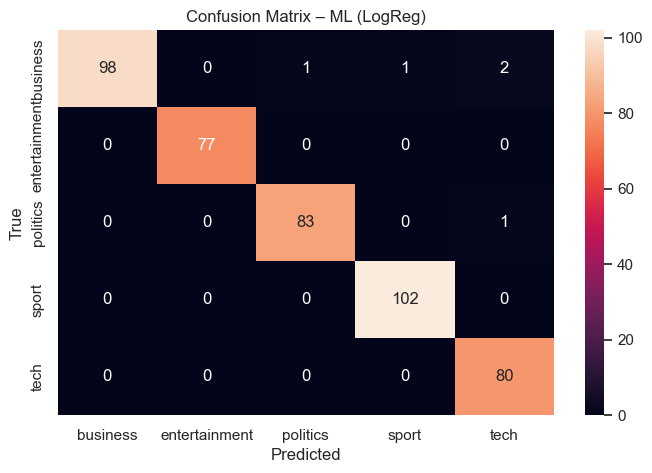

In [37]:
cm_ml = confusion_matrix(y_test_int, y_ml_pred)
sns.heatmap(cm_ml, annot=True, fmt="d",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix – ML (LogReg)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


B1.3. 5 misclassified examples (ML)

In [43]:
mis_idx = np.where(y_ml_pred != y_test_int)[0]
print("Total misclassified (ML):", len(mis_idx), "\n")

# Get test indices - reconstruct if not available (same random_state ensures same split)
if 'test_idx' not in globals():
    indices = np.arange(len(y_int))
    _, _, _, _, _, _, _, test_idx = train_test_split(
        X_tfidf, X_seq, y_int, indices,
        test_size=0.2,
        random_state=RANDOM_STATE,
        stratify=y_int
    )

for i in mis_idx[:5]:
    print("_"*120)
    print("True:", label_encoder.inverse_transform([y_test_int[i]])[0])
    print("Pred:", label_encoder.inverse_transform([y_ml_pred[i]])[0])
    original_idx = test_idx[i]
    text_preview = df.iloc[original_idx]["clean_text"]
    print("Text:", text_preview[:100] + "..." if len(text_preview) > 100 else text_preview)


Total misclassified (ML): 5 

________________________________________________________________________________________________________________________
True: business
Pred: tech
Text: card fraudsters targeting web new safeguards on credit and debit card payments in shops has led frau...
________________________________________________________________________________________________________________________
True: politics
Pred: tech
Text: uk firms embracing ecommerce uk firms are embracing internet trading opportunities as never before e...
________________________________________________________________________________________________________________________
True: business
Pred: politics
Text: golden rule intact says exaide chancellor gordon brown will meet his golden economic rule with a mar...
________________________________________________________________________________________________________________________
True: business
Pred: tech
Text: bt offers equal access to rivals bt has mo